In [128]:
import os

import rioxarray
import geopandas as gpd
import pandas as pd
import numpy as np
import xrspatial
from shapely import Point, LineString, Polygon
import matplotlib.pyplot as plt

from valleys.utils import setup_wbt
from valleys.catchment import get_catchment_data
from valleys.cross_section import plot_cross_section_profile, map_cross_sections, preprocess_channel, get_cross_section_points

In [39]:
wbt = setup_wbt("~/opt/WBT/", "../data/wb_outputs/")

In [4]:
manifest = pd.read_csv("../data/sample_subbasins/subbasin/subbasins.csv")
manifest

,huc12,raster_name,path
0,180101100904,filled_dem,/Users/arthurkoehl/programs/pasternack/valleys...
1,180101100904,d8_pntr,/Users/arthurkoehl/programs/pasternack/valleys...
2,180101100904,subbasins,/Users/arthurkoehl/programs/pasternack/valleys...
3,180101100904,streams,/Users/arthurkoehl/programs/pasternack/valleys...
4,180701020604,filled_dem,/Users/arthurkoehl/programs/pasternack/valleys...
5,180701020604,d8_pntr,/Users/arthurkoehl/programs/pasternack/valleys...
6,180701020604,subbasins,/Users/arthurkoehl/programs/pasternack/valleys...
7,180701020604,streams,/Users/arthurkoehl/programs/pasternack/valleys...
8,180400060403,filled_dem,/Users/arthurkoehl/programs/pasternack/valleys...
9,180400060403,d8_pntr,/Users/arthurkoehl/programs/pasternack/valleys...


# HUC 12

In [221]:
df = manifest.loc[manifest['huc12'] == 180101100904]
df

,huc12,raster_name,path
0,180101100904,filled_dem,/Users/arthurkoehl/programs/pasternack/valleys...
1,180101100904,d8_pntr,/Users/arthurkoehl/programs/pasternack/valleys...
2,180101100904,subbasins,/Users/arthurkoehl/programs/pasternack/valleys...
3,180101100904,streams,/Users/arthurkoehl/programs/pasternack/valleys...


In [222]:
subbasin_file = df.loc[df['raster_name'] == 'subbasins', 'path'].iloc[0]
stream_file = df.loc[df['raster_name'] == 'streams', 'path'].iloc[0]
pntr_file = df.loc[df['raster_name'] == 'd8_pntr', 'path'].iloc[0]
dem_file = df.loc[df['raster_name'] == 'filled_dem', 'path'].iloc[0]

## Catchment

In [237]:
id = 5

In [238]:
data = get_catchment_data(wbt, dem_file, subbasin_file, stream_file, pntr_file, id)
dem = rioxarray.open_rasterio(data['dem']).squeeze()
hand = rioxarray.open_rasterio(data['hand']).squeeze()
curv = rioxarray.open_rasterio(os.path.join(wbt.work_dir, data['profile_curvature'])).squeeze()
flowline = gpd.read_file(data['streamline'])
stream_raster = rioxarray.open_rasterio(data['streams']).squeeze()

hand = hand.where(hand != -32768, np.nan)

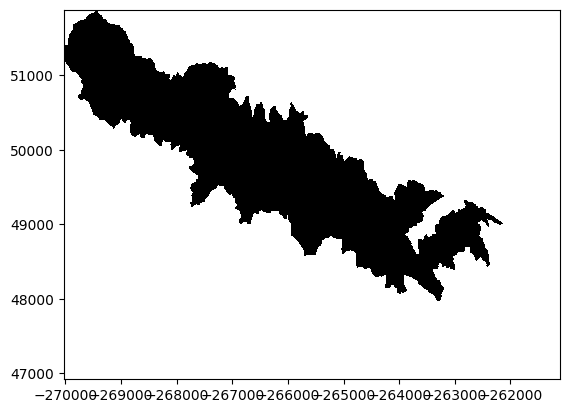

In [239]:
centerline = preprocess_channel(flowline['geometry'][0], method='centerline', hand=hand, contour_levels = [0,5,10,100])

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

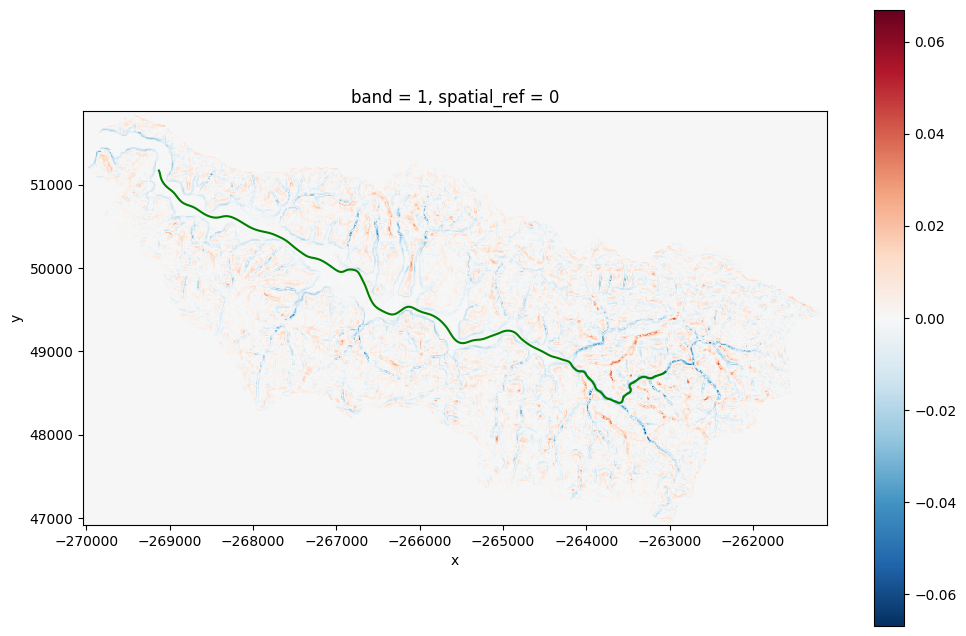

In [240]:
fig, ax = plt.subplots(figsize=(12,8))
curv.plot(ax=ax)
#flowline.plot(ax=ax, color='red')
gpd.GeoDataFrame(geometry=[centerline], crs=3310).plot(ax=ax, color='green')

In [246]:
points_df = get_cross_section_points(centerline, hand, curv, xs_spacing=50, xs_width=500, xs_point_spacing=5)
points_df

,alpha,elevation,slope,point,cross_section
0,-500,164.286256,0.031627,POINT (-263398.43993980554 49115.31255390949),0
1,-495,157.309327,0.010781,POINT (-263394.86948112777 49111.812293229144),0
2,-490,157.309327,0.010781,POINT (-263391.29902245 49108.312032548805),0
3,-485,157.309327,0.010781,POINT (-263387.7285637722 49104.81177186846),0
4,-480,145.671129,-0.000177,POINT (-263384.15810509445 49101.31151118811),0
...,...,...,...,...,...
197,480,155.005905,0.000000,POINT (-268720.26780236186 51421.42504781846),151
198,485,155.005905,0.000000,POINT (-268715.9613529776 51423.965617380796),151
199,490,155.005905,0.000000,POINT (-268711.6549035934 51426.50618694314),151
200,495,160.067489,0.000000,POINT (-268707.34845420916 51429.04675650548),151


<Axes: >

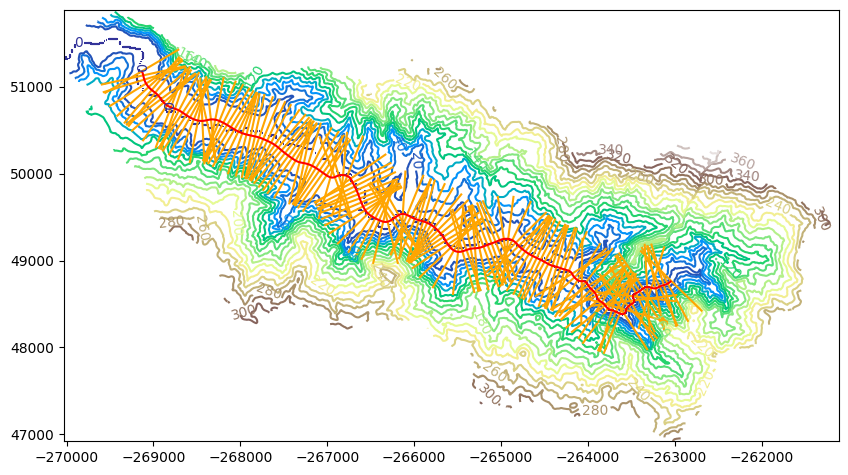

In [247]:
from valleys.cross_section import _get_extent, _generate_cross_section_lines
linestring = centerline
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

cs = ax.contour(hand, cmap='terrain', levels=25,
                     extent=_get_extent(hand), origin='upper')
ax.clabel(cs, inline=True, fontsize=10)
lines = _generate_cross_section_lines(points_df)
lines.plot(ax=ax, color='orange')

if not isinstance(linestring, gpd.GeoDataFrame):
    linestring = gpd.GeoDataFrame(geometry=[linestring])
linestring.plot(ax=ax, color='red')

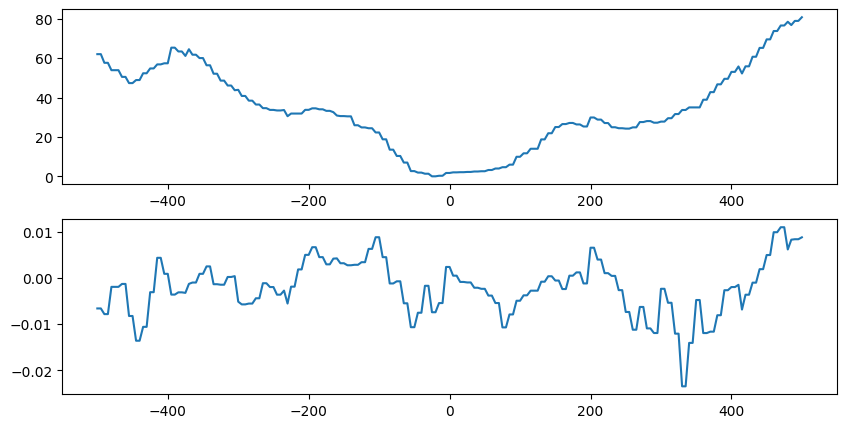

In [262]:
df = points_df.loc[points_df['cross_section'] == 49, ['alpha', 'elevation', 'slope']]
df = df.loc[np.isfinite(df['elevation'])]
fig, ax = plt.subplots(2,1, figsize=(10,5))

ax[0].plot(df['alpha'], df['elevation'])
ax[1].plot(df['alpha'], df['slope'])